### Justin Ehly
#### HW8 - NLP
#### Answer explanations and discussion are after the code for each section.

In [2]:
import numpy as np
import requests
import re
import nltk
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd




---
Gather Move Reviews from IMDB.com

In [12]:

class scraper():
    '''
        Build web scraper to gather the top 50 comedies from imdb.com
        - gather the titles and individual comedy movie page urls
        - gather the main talent in each movie, mainly director(s) and main star(s)
        - gather the permalinks to <user selected> user comments from each movie's page
        - remove movies that don't have any comments
    '''
    
    def __init__(self, reviews):

        # set imdb header
        self.imdb_header = 'https://www.imdb.com'
        
        # set imdb reviews footer
        self.review_footer = 'reviews?ref_=tt_urv'        
        
        # number of movie reviews per movie
        self.movie_reviews = reviews
    

    # get a list of the 50 comedies listed on the top comedies page on imdb along with the link to each movie's individual page    
    def get_comedies(self):
        # download 50 comedy movie titles and links from imdb
        URL = 'https://www.imdb.com/search/title/?genres=comedy&explore=title_type,genres&pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=3396781f-d87f-4fac-8694-c56ce6f490fe&pf_rd_r=E9DKJDX8CMCD24P485G8&pf_rd_s=center-1&pf_rd_t=15051&pf_rd_i=genre&ref_=ft_gnr_pr1_i_1'
        response = requests.get(URL)
        soup = BeautifulSoup(response.text, 'lxml')

        # grab page contents with movie links and titles
        movies = soup.select('h3.lister-item-header')    

        # get links to each movie page
        movie_links = [link.attrs.get('href') for link in soup.select('h3.lister-item-header a')]
        movie_links = [self.imdb_header + link for link in movie_links]
        movie_links = [link + self.review_footer for link in movie_links]
        self.movie_links = movie_links
        
        # extrap the titles/ actors
        comedy_titles = []
        for idx, movie in enumerate(movies):
            ms = movie.get_text()
            mov = (' '.join(ms.split()).replace('.',''))
            mov = mov.split(' (')[0]
            mov = mov[len(str(idx))+1:]
            comedy_titles.append(mov)
        self.comedy_titles = comedy_titles
        
        # get the main directors and actors
        talent = soup.findAll('p', {'class':''})
        all_talent = []
        for t in talent:  # return a chunk of html with director and stars with titles, needs to be cleaned up
            ms = t.text      # just grab the text from the html
            names = ' '.join(ms.split()).replace('.','')    # extrap the names and titles
            if str.find(names,'|'):         # split up the list by titles ('Director(s)', 'Star(s)')
                names = names.split('|')
            talent = []
            for n in names:
                talent.append(n.split(': ')[1])   # drop the title from each list

            talent = [t.split(', ') for t in talent]
            talent = [item for sublist in talent for item in sublist]

            #clean up spaces at the beginning or end in case they escaped
            talent = [i[1:] if i[0] == ' ' else i[:-1] if i[-1]== ' ' else i for i in talent]
            all_talent.append(talent)
        
        all_talent = [n for m in all_talent for n in m]  # unpack the list of names
        all_talent = set(all_talent) # remove duplicates!
        
        self.talent_names = all_talent
        
    # remove the movies with less than 5 reviews
    def clean_up(self):
        for x,i in enumerate(self.permalinks):
            if len(i) < 5:
                print(self.comedy_titles[x])
                print(len(i))
                self.permalinks.pop(x)
                self.comedy_titles.pop(x)
                self.movie_links.pop(x)
        return self        

    # grab the permalinks from each comedy's move page on imdb    
    def get_permalinks(self):
        self.get_comedies()
        movie_links = self.movie_links
        permalinks = []
        for link in movie_links:
            response = requests.get(link)
            soup = BeautifulSoup(response.text, 'lxml')
            plinks = [self.imdb_header + link.attrs.get('href') for link in soup.select('div.actions.text-muted a') if link.attrs.get('href')[1:7] == 'review']
            plinks = plinks[ 0 : self.movie_reviews ]
            permalinks.append(plinks)
        
        
        self.permalinks = permalinks
        
        self.clean_up()
        
        return self


    
       
# pass how many reviews per movie
imdb = scraper(5).get_permalinks()                



In [13]:
count_permalinks = len([item for sublist in imdb.permalinks for item in sublist])
print(f'There are {count_permalinks} permalinks for {len(imdb.comedy_titles)} comedies with a total of {len(imdb.talent_names)} unqiue directors and actors from the imdb website')


There are 250 permalinks for 50 comedies with a total of 221 unqiue directors and actors from the imdb website


In [14]:
# Use Beautiful Soup to extract the reviews from each review page within imbd.
links = imdb.permalinks[0]

class movie_reviews():
    def __init__(self, permalinks_list):
        self.permalinks_list = permalinks_list
        
    # cycle through all movies and return a list of lists of movie reviews for each movie
    def get_movie_reviews(self):
        reviews = []
        for single_movie_permalinks in self.permalinks_list:
            single_comedy_reviews = self.movie_review_page_cycling(single_movie_permalinks)
            reviews.append(single_comedy_reviews)
        
        self.reviews = reviews
        return self

    # cycle through each movie's pages of reviews
    def movie_review_page_cycling(self, links):
        reviews = []
        for link in links:
            review = self.get_review(link)
            reviews.append(review)
        
        return reviews

    # get single review
    def get_review(self, link):
        response = requests.get(link)
        soup = BeautifulSoup(response.text, 'lxml')
         
        review =  soup.find('div', {'class':'text show-more__control'}).text
        return review


#reviews = movie_review_page_cycling(links)
#print(f'Reviews for {imdb.comedy_titles[0]}')
#for review in reviews:
#    print(f'{review}\n')

# only pass the first 100 permalinks from the first 20 comedies
reviews = movie_reviews(imdb.permalinks[:21]).get_movie_reviews()

    

In [15]:
# confirm how many reviews each movie title has
[len(i) for i in reviews.reviews]

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

In [17]:
# unpack the movie reviews into a list of 100 reviews!
movie_reviews = [item for sublist in reviews.reviews for item in sublist]
len(movie_reviews)

105

In [18]:
import itertools

l = [[i for i in itertools.repeat(imdb.comedy_titles[x],5)] for x in range(21)]
titles = [item for subitem in l for item in subitem]
len(titles)
    

105

In [19]:
set(titles)

{' Fresh',
 'Atlanta',
 'CODA',
 "Don't Look Up",
 'Encanto',
 'Everything Everywhere All at Once',
 'Licorice Pizza',
 'Minx',
 'Our Flag Means Death',
 'Peacemaker',
 'Sonic the Hedgehog 2',
 'The Adam Project',
 'The Bubble',
 'The Lost City',
 'The Marvelous Mrs Maisel',
 'The Office',
 'The Unbearable Weight of Massive Talent',
 'The Worst Person in the World',
 'This Is Us',
 'Turning Red',
 'Upload'}

In [20]:
movie_reviews[0]

'Ruby Rossi (Emilia Jones) is a Child of Deaf Adults. Her father Frank (Troy Kotsur), older brother Leo (Daniel Durant), and mother Jackie (Marlee Matlin) are all deaf. She is their interpreter and tries to protect them from the hearing world. She wakes up at 3 every morning to join the family fishing boat as the only hearing crew member. At school, she joins the choir and her teacher, Bernardo "Mr. V" Villalobos (Eugenio Derbez), takes an interest in her. She finds herself torn between helping her family at home or setting off into the world on her own.This is sweet. It is surprisingly funny. It has family drama. It\'s a coming-of-age movie. It\'s an Oscar best winning picture. Every one of those statements are true but the last one leads to a debate. For sure, this is not the most artistically adventurous film. It has an interesting subject matter but it\'s not pushing the envelope as much peeling back the layer. This film is actually a very audience-friendly film. Years from now, th

---
1.	In Python, select any one of the clustering methods covered in this course. Run it over the collection of reviews, and show at least two different ways of clustering the reviews, e.g., changing k in k-Means clustering or changing where you “cut” in Agnes or Diana.  

In [21]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib as mpl
from sklearn.feature_extraction.text import TfidfVectorizer

def kmeans_clustering(reviews, n_clusters, n_words):
    vectorizer = TfidfVectorizer(stop_words='english', max_features = n_words)  # vectorize and remove stop words
    reviews_vectorized = vectorizer.fit_transform(reviews)
    print(f'The Shape for the vectorized reviews {reviews_vectorized.shape}')
   
    kmeans = KMeans(n_clusters = n_clusters , random_state = 42)
    kmeans.fit(reviews_vectorized)
    clusters = kmeans.predict(reviews_vectorized)
    pca = PCA(n_components=3)
    dense_vect = reviews_vectorized.toarray()
    dims = pca.fit_transform(dense_vect)

    scatter_x = dims[:,0]
    scatter_y = dims[:,1]

    plt.style.use('ggplot')

    fig, ax = plt.subplots(figsize = (20,10))

    # look at most important features
    mreviews = pd.DataFrame(data = dense_vect, columns = vectorizer.get_feature_names_out() )
    mreviews['title'] = titles
    mreviews['cluster'] = clusters
    cols = ['title','cluster'] + [col for col in mreviews if col not in ['title','cluster']]
    mreviews = mreviews[cols]
    print(f'The top {n_words} words are {[i for i in mreviews[2:]]}')
     
    # color map for NUMBER_OF_CLUSTERS we have
    clrs = ['green', 'blue','red','orange','purple','indianred','chocolate','yellow','lawngreen','fuchsia','lightblue']

    for i,x in enumerate(clusters):
        ax.scatter(scatter_x[i], scatter_y[i], c = clrs[x], label = x)
        ax.annotate(titles[i],(scatter_x[i], scatter_y[i]) )
  
    ax.set_title(f'K-means {n_clusters} Clusters')
    ax.set_facecolor('white')
    ax.set_xlabel("PCA 0")
    ax.set_ylabel("PCA 1")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
   
    plt.show()
    


    return reviews_vectorized, clusters, mreviews


The Shape for the vectorized reviews (105, 51)
The top 51 words are ['title', 'cluster', 'action', 'actors', 'adam', 'alana', 'best', 'bit', 'cast', 'character', 'characters', 'comedy', 'did', 'different', 'does', 'don', 'end', 'family', 'film', 'fun', 'funny', 'gets', 'going', 'good', 'great', 'just', 'life', 'like', 'lot', 'love', 'make', 'mother', 'movie', 'movies', 'new', 'old', 'people', 'probably', 'quite', 'real', 'really', 'say', 'season', 'series', 'shows', 'story', 'things', 'think', 'time', 'watch', 'way', 'world', 'year']


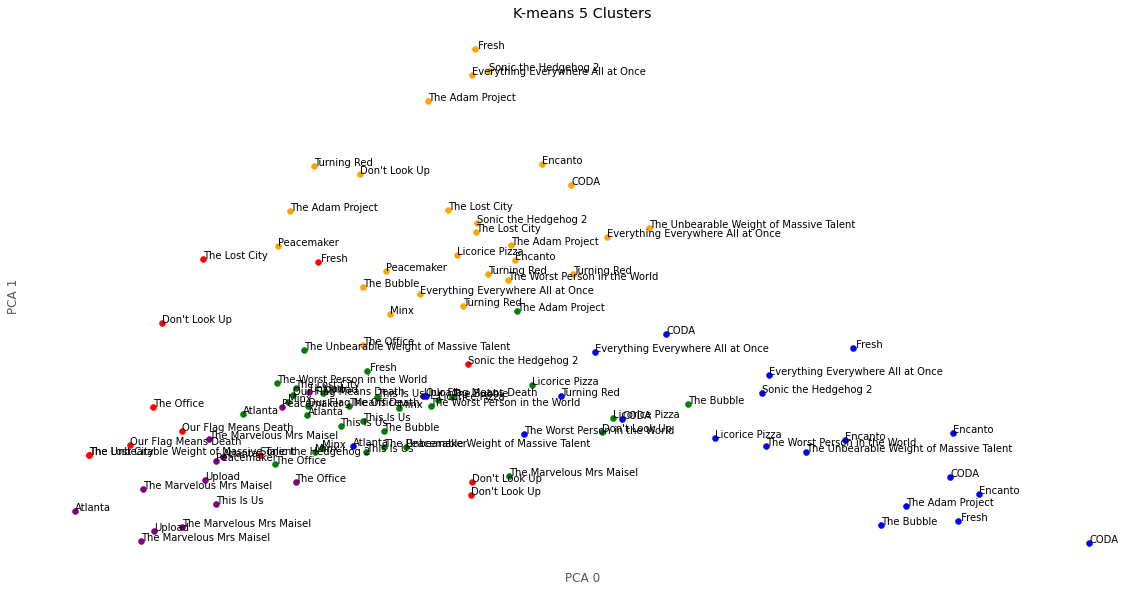

In [22]:
words = 51
clusters = 5
k5 = kmeans_clustering(movie_reviews, clusters, words)


### Start HW8
<br>
1.	In Python, load one of the sentiment vocabularies referenced in the textbook, and run the sentiment analyzer as explained in the corresponding reference. Add words to the sentiment vocabulary, if you think you need to, to better fit your particular text collection.



In [26]:
from afinn import Afinn

afn = Afinn(emoticons=True)

# run sentiment analysis using Afinn
sentiment_polarity = [afn.score(review) for review in movie_reviews]
predicted_sentiments = ['positive' if score >= 1.0 else 'negative' if score <= -1.0 else 'neutral' for score in sentiment_polarity]


# create dataframe with the results
data = {'Review No.' : list(range(1,106,1)), 'Movie Title' : titles, 'Sent Polarity': sentiment_polarity, 'Pred Sentiment': predicted_sentiments, 'Cluster': k5[1]}
revs = pd.DataFrame(data = data)



In [27]:
pd.set_option('display.max_rows', None)
revs.sort_values(by = 'Sent Polarity', ascending=False)

,Review No.,Movie Title,Sent Polarity,Pred Sentiment,Cluster
32,33,Licorice Pizza,138.0,positive,1
44,45,Everything Everywhere All at Once,61.0,positive,1
64,65,The Office,55.0,positive,0
54,55,Sonic the Hedgehog 2,54.0,positive,1
86,87,The Worst Person in the World,53.0,positive,1
61,62,The Office,52.0,positive,0
8,9,The Lost City,51.0,positive,3
72,73,The Marvelous Mrs Maisel,51.0,positive,4
1,2,CODA,42.0,positive,1
42,43,Everything Everywhere All at Once,40.0,positive,3


---

2.	For each of the clusters you created in homework 7, compute the average, median, high, and low sentiment scores for each cluster. 



In [28]:
low = pd.DataFrame(revs.groupby(by = ['Cluster']).min(),)
average = pd.DataFrame(revs.groupby(by = ['Cluster']).mean(),)
med = pd.DataFrame(revs.groupby(by = ['Cluster']).median())
high = pd.DataFrame(revs.groupby(by = ['Cluster']).max())
d = {'low': low['Sent Polarity'], 
     'average': average['Sent Polarity'], 
     'median': med['Sent Polarity'], 
     'high': high['Sent Polarity']}
cluster_sentiment = pd.DataFrame(data = d)
cluster_sentiment.reset_index(inplace=True)


In [29]:
cluster_sentiment

,Cluster,low,average,median,high
0,0,-4.0,13.032258,10.0,55.0
1,1,-4.0,28.909091,20.0,138.0
2,2,-3.0,11.000000,12.5,28.0
3,3,-8.0,18.814815,16.0,51.0
4,4,-5.0,17.153846,14.0,51.0


---
Explain whether you think this reveals anything interesting about the clusters.
<br>
<font color='blue'>Comment</font>: Interesting, there is clear separation between the clusters by each number from low to median. Clusters 3 and 4 both have the same high value and similar other values telling me that based on using 51 top words to cluster, there may only be 4 realistic clusters based on this analysis. 

---


---
Final Comments:<br>
I found that most of the reviews I pulled from the IMDB website have a more positive slant, and that is more than likely because I just selected the top 5 reviews of each film. A better approach is to randomly select reviews from each movie, but that requires more complex web scraping skills or perhaps I just grab all the reviews and once I have them captured, then randomly grab using a bag of reviews approach.
<br> Keeping in mind that I mainly took the top 5 reviews of each movie or imdb comedy listing, a few neutral and negative reviews did come in, more than likely because the movie has only a few reviews and how imdb is ranking the reviews.